# Young (2010) method to simulate a cross-section

Solving economic models involves (i) finding the **optimal response of individuals** given the state of the economy (the policy functions); (ii) given the policy functions, **simulating the model**. While usually one must show great ingenuity and creativity for the former, the latter is often seen as trivial and not even mentioned. However, in this notebook I describe a simulation procedure that deserves to be advertised. Namely, I describe [Young's method (2010)](https://ideas.repec.org/a/eee/dyncon/v34y2010i1p36-41.html) to simulate a large number (infinity) of individuals.

## Why should we care?

In economies with heterogeneous agents, often there is no such thing as a [representative agent](https://en.wikipedia.org/wiki/Representative_agent#:~:text=Economists%20use%20the%20term%20representative,the%20same%20type%20are%20identical.). Generally, one must follow a large number of individuals. For instance, one may be interested in knowing how the average wage responds to an increase in labor productivity. If workers are different (in terms of skills, experience, firms in which they work, etc.), one must take into consideration changes in individuals' wages to determine how the average wage moves.

## The method

The method avoids simulating a panel of agents. Instead, the idea is to simulate directly the distribution.
In practice, one chooses a grid $[w_1, w_2, ..., w_N]$

If a measure $m$ of workers choose to consume $w$, with $w \in [w_{n}, w_{n+1}]$, then the mass assigned to the grid point $w_{n}$ is equal to $m \times p$ and the mass assigned to the grid point $w_{n+1}$ is $m \times (1 - p)$ with

$$ p = 1 - \frac{w - w_{n}}{w_{n+1} - w_{n}} $$

If $w$ is very close to $w_{n}$, then most of the mass $m$ will be assigned to this point. In the limit case, if $w$ is equal to $w_{n}$, $100$ \% of the mass is assigned to $w_{n}$.

Simple, right? The code below is an implementation of [Young's method (2010)](https://ideas.repec.org/a/eee/dyncon/v34y2010i1p36-41.html) using [Julia](https://julialang.org/).

## Implementation

### Preliminaries

Let's first start by loading a few packages and declaring auxiliaries functions. In particular, given a value $w$ we need a function that returns the closest value $w_k$, where $w_k$ is picked from given grid $w_1, w_2, ..., w_N$

In [30]:
using Plots
using Distributions
using StatsBase

# Matlab like function
function linspace(z_start::Real, z_end::Real, z_n::Int64)
    return collect(range(z_start,stop=z_end,length=z_n))
end

# Not my function. Credit to: https://discourse.julialang.org/t/findnearest-function/4143/4
function closest_index(a::Vector,x::Real)

    if isempty(a) == true
      error("xGrid is empty in function closest_index.")
    end

    if isnan(x) == true
      error("val is NaN in function closest_index.")
    end

   idx = searchsortedfirst(a,x)
   if (idx==1); return idx; end
   if (idx>length(a)); return length(a); end
   if (a[idx]==x); return idx; end
   if (abs(a[idx]-x) < abs(a[idx-1]-x))
      return idx
   else
      return idx-1
   end
end

# Returns best index and best value
function closest_value_and_index(xGrid::Vector, val::Real)

    # get index
    ibest = closest_index(xGrid, val)

    # Return best value on grid, and the corresponding index
    return xGrid[ibest], ibest

end


closest_value_and_index (generic function with 1 method)

### Approximate a distribution with a single mass point

To warm up, let's see how the method works when the true underlying distribution is constituted of **a single mass point**.

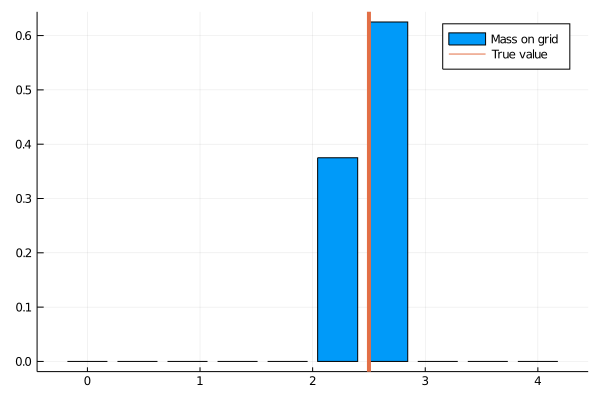

In [35]:
## True Value
w = 2.5    #True value
mass = 1.0 #Mass at the true value

## Approximation
nW=10 #Number of grid points
w_grid=linspace(0.0, 4.0, nW) #Location of grid points
hw_grid=zeros(nW); #Initialization

w_min = minimum(w_grid) #Upper bound for the grid
w_max = maximum(w_grid) #Lower bound for the grid
nW = length(w_grid) #Number of points on the grid

# Project true value on the grid:
(wValue_proj, wIndex_proj) = closest_value_and_index(w_grid, w)

# To store the location of the value below and above the true value:
wIndex_below = 0
wIndex_above = 0

# If the true value is above the projection
if w >= wValue_proj
    wIndex_below = wIndex_proj
    wIndex_above = wIndex_proj + 1
# If the true value is below the projection
elseif w < wValue_proj
    wIndex_below = wIndex_proj -1 
    wIndex_above = wIndex_proj 
end

# Boundary cases
if wIndex_proj == 1
    wIndex_below = 1
    wIndex_above = 2
elseif wIndex_proj == nW
    wIndex_below = nW - 1
    wIndex_above = nW
end

# Special case 1: w < w_min
if w <= w_min
    p = 1
elseif w >= w_max
# Special case 2: w > w_max
    p = 0
else
    p = 1.0 - ((w - w_grid[wIndex_below])/(w_grid[wIndex_above] - w_grid[wIndex_below]))
    p = min(1.0, max(0.0, p))
end

# Spread the mass:
# 1. Point below
hw_grid[wIndex_below] += p*mass

# 2. Point above:
hw_grid[wIndex_above] += (1.0 - p)*mass;

p0 =bar(w_grid, hw_grid, label = "Mass on grid")
plot!(p0, [w], seriestype = :vline, label="True value", linewidth = 4)

Because the true value is not a point of our grid (that would be a miracle), the mass is spread between the two closest points. However, we still get the mean right. We will see below that this property extends to distributions with support constituted of several points:

In [34]:
println("True mean $(w)")
println("Approximate mean $(round(mean(w_grid, weights(hw_grid./sum(hw_grid))), digits = 4))")

True mean 2.5
Approximate mean 2.5


### Approximate a multi-point distribution

Now, let's see how well [Young's method (2010)](https://ideas.repec.org/a/eee/dyncon/v34y2010i1p36-41.html) works when the true underlying distribution has positive mass for **a finite number of points**. To keep things pretty, let's assume that the true distribution has the shape of a Normal distribution, but we truncate the tails.

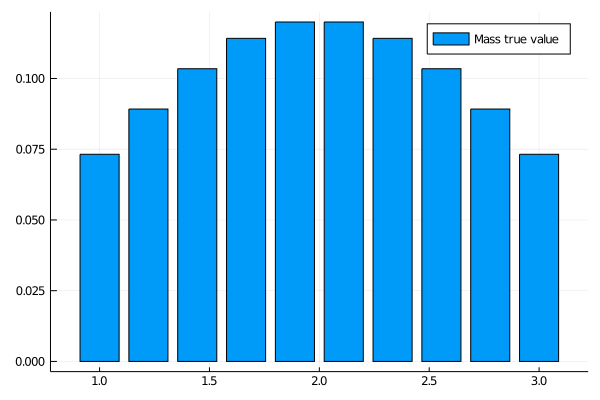

In [21]:
Nw_true = 10 #Number of points with positive mass
w_true_lb = 1.0 #lower bound 
w_true_ub = 3.0 #upper bound
w_true = linspace(w_true_lb, w_true_ub, Nw_true) 
d = truncated(Normal((w_true_lb + w_true_ub)/2), w_true_lb, w_true_ub)
mass_true = pdf.(d, w_true)
mass_true = mass_true./sum(mass_true);
p0 = bar(w_true, mass_true, label="Mass true value")
display(p0)

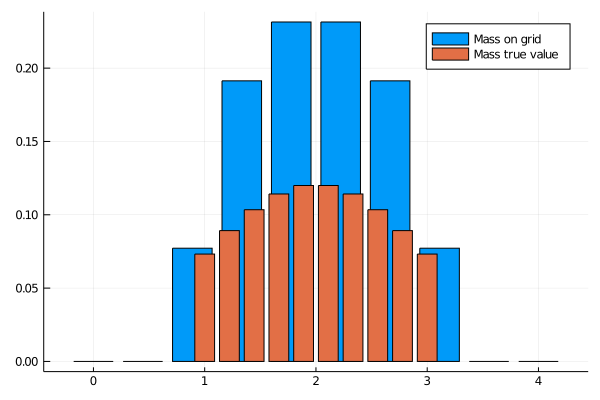

In [22]:
w_min = minimum(w_grid)
w_max = maximum(w_grid)
nW = length(w_grid)

hw_grid=zeros(nW);


for (wIndexTrue, w) in enumerate(w_true)
    
    mass = mass_true[wIndexTrue] #mass

    # Project true value on the grid:
    (wValue_proj, wIndex_proj) = closest_value_and_index(w_grid, w)

    # To store the location of the value below and above the true value:
    wIndex_below = 0
    wIndex_above = 0

    # If the true value is above the projection
    if w >= wValue_proj
        wIndex_below = wIndex_proj
        wIndex_above = wIndex_proj + 1
    # If the true value is below the projection
    elseif w < wValue_proj
        wIndex_below = wIndex_proj -1 
        wIndex_above = wIndex_proj 
    end

    # Boundary cases
    if wIndex_proj == 1
        wIndex_below = 1
        wIndex_above = 2
    elseif wIndex_proj == nW
        wIndex_below = nW - 1
        wIndex_above = nW
    end

    # Special case 1: w < w_min
    if w <= w_min
        p = 1
    elseif w >= w_max
    # Special case 2: w > w_max
        p = 0
    else
        p = 1.0 - ((w - w_grid[wIndex_below])/(w_grid[wIndex_above] - w_grid[wIndex_below]))
        p = min(1.0, max(0.0, p))
    end

    p = 1.0 - ((w - w_grid[wIndex_below])/(w_grid[wIndex_above] - w_grid[wIndex_below]))
    p = min(1.0, max(0.0, p))

    # Spread the mass:
    # 1. Point below
    hw_grid[wIndex_below] += p*mass

    # 2. Point above:
    hw_grid[wIndex_above] += (1.0 - p)*mass

end

bar(w_grid, hw_grid, label="Mass on grid")
bar!(w_true, mass_true, label="Mass true value")

A good property of [Young's method (2010)](https://ideas.repec.org/a/eee/dyncon/v34y2010i1p36-41.html) is that, **as long as the grid is wide enough** to so that true values fall within it, **the mean of the true underlying distribution is preserved**:

In [23]:
println("True mean $(round(mean(w_true, weights(mass_true./sum(mass_true))), digits = 4))")
println("Approximate mean $(round(mean(w_grid, weights(hw_grid./sum(hw_grid))), digits = 4))")

True mean 2.0
Approximate mean 2.0


However, there are some **approximation errors** when **higher moments** are involved such as the variance, or when calculating **percentiles**. But the finest the grid, the better the approximation gets.

In [24]:
println("True median $(round(quantile(w_true, weights(mass_true./sum(mass_true)), 0.5), digits = 4))")
println("Approximate median $(round(quantile(w_grid, weights(hw_grid./sum(hw_grid)), 0.5), digits = 4))")

println("True variance $(round(var(w_true, weights(mass_true./sum(mass_true))), digits = 4))")
println("Approximate variance $(round(var(w_grid, weights(hw_grid./sum(hw_grid))), digits = 4))")

True median 1.9567
Approximate median 1.8519
True variance 0.3465
Approximate variance 0.3836


### Using a panel of agents

Alternatively, one may use a large number of agents to approximate the true underlying distribution. The idea is that if the number of agents is large enough, the [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem) will kick in. The issue is that we need a large number of agents to get the approximation right, as illustrated below:

True mean 2.0
Approximate mean 1.9955
True median 1.9567
Approximate median 1.9971
True variance 0.3465
Approximate variance 0.2754


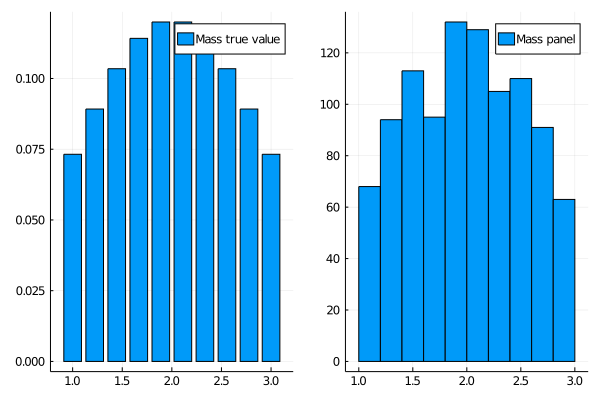

In [25]:
nb_agents = 1000
w_agents = rand(d, nb_agents);

println("True mean $(round(mean(w_true, weights(mass_true./sum(mass_true))), digits = 4))")
println("Approximate mean $(round(mean(w_agents), digits = 4))")

println("True median $(round(quantile(w_true, weights(mass_true./sum(mass_true)), 0.5), digits = 4))")
println("Approximate median $(round(quantile(w_agents, 0.5), digits = 4))")

println("True variance $(round(var(w_true, weights(mass_true./sum(mass_true))), digits = 4))")
println("Approximate variance $(round(var(w_agents), digits = 4))")

p0 = bar(w_true, mass_true, label="Mass true value")
p1 = histogram(w_agents, label="Mass panel")
plot(p0,p1)

With 1000 agents, the approximation is not exceptional. Let's try to increase the number of agents. The following plot shows that the approximation gets better as we increase the number of agents, but a very 
large number of agents is needed:

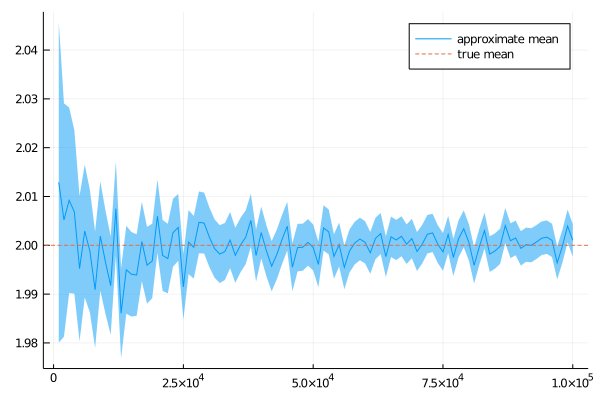

In [26]:
w_agents = []
grid_agents = collect(1000:1000:100000)
mean_agents = zeros(length(grid_agents))
std_agents = zeros(length(grid_agents))

for (i, nb_agents) in enumerate(grid_agents)
    push!(w_agents, rand(d, nb_agents))
    mean_agents[i] = mean(w_agents[i])
    std_agents[i] = std(w_agents[i])
end

CI = 1.960.*std_agents./sqrt.(grid_agents); #95% confidence interval. t-test is approximately a z-test because large number of agents.
p0 = plot(grid_agents, mean_agents, ribbon = CI, label = "approximate mean")
plot!(p0,[mean(w_true, weights(mass_true./sum(mass_true)))], linetype = :hline, label = "true mean", linestyle = :dash)

## Conclusion

When possible, simulating directly a distribution instead of using a panel is a good idea. [Young's method (2010)](https://ideas.repec.org/a/eee/dyncon/v34y2010i1p36-41.html)
allows to do that, while preserving the mean of the true distribution.

### References

* Young, Eric R. "Solving the incomplete markets model with aggregate uncertainty using the Krusell–Smith algorithm and non-stochastic simulations." Journal of Economic Dynamics and Control 34.1 (2010): 36-41.

### Appendix

In [27]:
versioninfo()

Julia Version 1.5.1
Commit 697e782ab8 (2020-08-25 20:08 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-9.0.1 (ORCJIT, skylake)
